# Read in data and set up plotting

In [2]:
import pandas as pd
import numpy as np
import ast
from mlxtend.evaluate import permutation_test
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, cdist
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import permutation
import random
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from numpy import std, mean, sqrt
import itertools
import networkx as nx
from numpy.random import permutation
import os
import editdistance
import random
from mlxtend.evaluate import permutation_test as ml_permutation_test
import pickle 
import pylcs
random.seed(416)
np.random.seed(416)


def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
            "#826AED",  # Medium slate blue
            "#00A896",  # Persian green
            "#D41876",  # Telemagenta
            "#89DAFF",  # Pale azure
            "#F7B2AD",  # Melon
            "#342E37",  # Dark grayish-purple
            "#7DCD85",  # Emerald
            "#E87461",  # Medium-bright orange
            "#E3B505",  # Saffron
            "#2C3531",  # Dark charcoal gray with a green undertone
            "#D4B2D8",  # Pink lavender
            "#7E6551",  # Coyote
            "#F45B69",  # Vibrant pinkish-red
            "#020887",  # Phthalo Blue
            "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True


make_aesthetic()


def clean_condition_col(x):
    if x == "f_l":
        return "LowExposure\nLabeled"
    elif x == "f_u":
        return "LowExposure\nUnlabeled"
    elif x == "m_l":
        return "HiExposure\nLabeled"
    elif x == "m_u":
        return "HiExposure\nUnlabeled"
    elif x == "h":
        return "HumanControl"


df = pd.read_csv("../../data/experiment_data/data_clean_with_elab.csv")
df['init_array'] = df['init_array'].apply(lambda x: eval(x)
                                          if isinstance(x, str) else x)
df['clean_condition'] = df['condition'].apply(lambda x: clean_condition_col(x))
df.head()

,Unnamed: 0,response_id,participant_id,response_text,response_date,condition,condition_order,item,response_chain,init_array,...,idea5_txt,idea_minus_excluded5_txt,idea6_txt,idea_minus_excluded6_txt,source,trial_no,trial_no_excluded,elab_ibf,elab_n_tokens,clean_condition
0,0,99ae32b8-e477-4d42-a98f-1a11116a8779,5c6d9a7d-79f2-491e-8592-5a4917313807,Dog chew toy,2023-07-26 02:15:58,f_l,3,shoe,6,"[5bc110cc-fea3-4728-bdba-e3a884bd63ff, ai_seed...",...,Paint it to look like a face with the opening ...,Paint it to look like a face with the opening ...,Convey that you're selling drugs,Convey that you're selling drugs,r/artificial,19,19.0,2.463967,3,LowExposure\nLabeled
1,1,632754e7-8297-4c55-91ec-485164c851f2,a062f627-4225-4634-9441-b6b41e0fe42f,Use the shoe as a ruler,2023-07-26 17:56:06,f_l,0,shoe,6,"[5d624ef0-ad38-441d-8982-86ad7da86fb1, 9d8bace...",...,doorstop to hold open doors,doorstop to hold open doors,Dog chew toy,Dog chew toy,r/singularity,20,20.0,2.954592,6,LowExposure\nLabeled
2,2,052f291a-1f95-4154-b217-504009cc5127,5c6d9a7d-79f2-491e-8592-5a4917313807,Kicking object to release stress,2023-07-26 02:14:34,m_l,2,tire,6,"[2c277bc2-10b6-42f0-876c-f0a86bf0eaa6, ai_seed...",...,yard art sculpture,yard art sculpture,diy ottoman or footstool,diy ottoman or footstool,r/artificial,19,18.0,3.809144,5,HiExposure\nLabeled
3,3,312cc305-86b0-4d72-97ea-d5b551618376,a062f627-4225-4634-9441-b6b41e0fe42f,use it as a damper,2023-07-26 18:02:28,h,2,tire,6,"[353a7741-c733-4ca1-988c-a809c2b24df6, d1087ef...",...,tire as an armchair or a shelf or as an exerci...,tire as an armchair or a shelf or as an exerci...,Carve the tire into a portrait of the first lady,Carve the tire into a portrait of the first lady,r/singularity,19,19.0,2.763950,5,HumanControl
4,4,1d7fb44d-adba-4ac4-9360-4126b214c2ae,b904b2d5-0217-41bf-9741-5203f3f46e34,use a a toy for pets to hide in and explore,2023-07-26 16:46:37,m_l,3,tire,6,"[ai_seed1238, 052f291a-1f95-4154-b217-504009cc...",...,garden planter with flowers,garden planter with flowers,fitness tool - tire flipping!,fitness tool - tire flipping!,Creative Mornings newsletter,20,19.0,4.684683,11,HiExposure\nLabeled


In [3]:
# In R, the final dataset has 3414 observations. Let's make sure all missing data is accounted for: 3414 should be |full data| - sum(exclude from analysis):
r_data = 3414
full_n = len(df)
accounted_for_exclusions =  np.sum(df['exclude_from_analysis'])

if full_n - accounted_for_exclusions == r_data:
    print("SUCCESS: We are all good: all missing data is accounted for in the exclude_from_analysis column") 
else:
    print("FAIL: Alert! Somewhere along the way we lost some data!!!")

SUCCESS: We are all good: all missing data is accounted for in the exclude_from_analysis column


# Get embeding of all ideas

The goal is to get a hash map `idea2vec` where key is text and value is sbert vector

In [12]:
def get_idea2vec(tdf):
    idea2vec_fn = "idea2vec.pickle"
    if not os.path.exists(idea2vec_fn):
        from sentence_transformers import SentenceTransformer
        model = SentenceTransformer('all-MiniLM-L12-v2')

        # Get a list of all ideas
        example_cols = [x for x in tdf.columns if "_txt" in x and "excluded" not in x]
        tdf['init_array_list'] = tdf[example_cols].values.tolist()
        all_ideas = []
        all_ideas.extend(tdf['response_text'])
        for x in example_cols:
            all_ideas.extend(tdf[x].to_list())
        all_ideas = list(set(all_ideas))
        all_ideas = [x.lower() for x in all_ideas] 
        
        # Get embeddings and create idea2vec mapping --> save to pickle
        embeddings = model.encode(all_ideas)
        idea2vec = dict(zip(all_ideas, embeddings))
        with open('idea2vec.pickle', 'wb') as f:
            pickle.dump(idea2vec, f)
        return tdf, idea2vec
    else:
        example_cols = [x for x in tdf.columns if "_txt" in x and "excluded" not in x]
        tdf['init_array_list'] = tdf[example_cols].values.tolist()
        with open('idea2vec.pickle', 'rb') as f:
            idea2vec = pickle.load(f)
        return tdf, idea2vec
df, idea2vec = get_idea2vec(df)

# Defune functions for inferential statistics



- We will first do a Kruskal Wallis test to see if the `dv` differs by `condition`. This is a non-parametric equivalent to ANOVA. If the dv differs by condition, we follow up with...

- Permutation tests on the difference in means with an fdr correction for multiple comparisons. I chose this analysis strategy because this stuff is weirdly distributed

- Do I do median or means actually?

In [13]:
def process_metrics(mydf, grouping_var=None, plot_type='point', num_perm=10*1000):
    """
    Process the metrics for a dataframe. This handles all the analysis. When fed a dataframe it looks for columns containing
    `sim` or `dist` and analyzes them. _
    
    Foreach distance or similarity dv:
    
    1. Conduct a Kurskal Wallis test (akin to non-parametric ANOVA) to see if `dv` differs by condition. 
    2. Plot the distribution of `dv` by condition
    3. Conduct pairwise permutation tests (testing for a difference in means) and apply an FDR adjustment to p-values
    
    Params
    - mydf: The dataframe
    - how ('boot', 'perm'): Either conduct a permutation test or feed in an already bootstrapped df 
    - paired (bool): Whether permutation test is on paired data
    - plot_type ('box', 'swarm', 'strip', 'bar', 'line', 'point'): Tye of plot
    """
    dist_metrics = [x for x in mydf.columns if "sim" in x or "dist" in x]
    print(dist_metrics)
    for dv in dist_metrics:
        plt.show()
        kruskal_wallis(mydf, "clean_condition", dv)
        display(pairwise_tests(mydf, "clean_condition", dv, grouping_var, num_perm))
        plot_distributions(mydf, "clean_condition", dv, plot_type)


def plot_distributions(tdf, group_col, data_col, plot_type):
    # We have many graphs, need to have each condition mapped to consistent color
    # Let's make it so unlabeled is a lighter shade of labeled

    if data_col.startswith("ai"):
        tdf = tdf.query("condition != 'h'")
    else:
        pass

    if plot_type == "box":
        graph_func = sns.boxplot
    elif plot_type == "swarm":
        graph_func = sns.swarmplot
    elif plot_type == "strip":
        graph_func = sns.stripplot
    elif plot_type == 'bar':
        graph_func = sns.barplot
    elif plot_type == "line":
        graph_func = sns.lineplot
    elif plot_type == "point":
        graph_func = sns.pointplot
    else:
        raise ValueError(f"Unknown plot_type: {plot_type}")

    color_dict = {
        'LowExposure\nLabeled': '#388659',
        'LowExposure\nUnlabeled': '#7EC99D',
        'HumanControl': 'black',
        'HiExposure\nLabeled': '#826AED',
        'HiExposure\nUnlabeled': '#D1C8F9',
    }
    data_col_clean = data_col.replace("_", " ").title()
    order = tdf.groupby(group_col)[data_col].mean().sort_values().index
    plt.figure(figsize=(14, 8))
    graph_func(data=tdf,
               x=group_col,
               y=data_col,
               order=order,
               palette=color_dict,
               errorbar=('ci', 95))
    plt.title(f"{data_col_clean} by condition")
    plt.show()


def kruskal_wallis(tdf, group_col, data_col):
    """Kurskal Wallis test for non-parametric group differences"""
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
    H, p = stats.kruskal(
        *[group[data_col].values for name, group in tdf.groupby(group_col)])
    if p < 0.05:
        print(
            f"We conducted a Kruskal Wallis test and found {data_col} differed by {group_col}, H={np.round(H, 2)}, p={p}"
        )
    else:
        print(
            f"We conducted a Kruskal Wallis test and found {data_col} DID NOT DIFFER by {group_col}, H={np.round(H, 2)}, p={p}"
        )
    return H, p


def pairwise_tests(tdf,
                   group_col,
                   data_col,
                   grouping_var=None,
                   num_permutations=10*1000):
    """Concducts pairwise permutation tests with FDR correction"""
    if data_col.startswith("ai"):
        tdf = tdf[tdf['condition'] != 'h']
    groups = tdf[group_col].unique()
    group_pairs = list(itertools.combinations(groups, 2))
    results = []

    for group1, group2 in group_pairs:
        group1_data = tdf[tdf[group_col] == group1][data_col]
        group2_data = tdf[tdf[group_col] == group2][data_col]

        p = perm_test_simple(group1_data, group2_data)

        mean_diff = np.mean(group1_data) - np.mean(group2_data)
        pooled_sd = sqrt((group1_data.std()**2 + group2_data.std()**2) / 2)
        ef_size = mean_diff / pooled_sd
        results.append([group1, group2, np.mean(group1_data), np.mean(group2_data), mean_diff, ef_size, p])

    results_df = pd.DataFrame(
        results,
        columns=['group1', 'group2', 'group1 mean', 'group2 mean', 'Diff in Means', "Cohen's d", 'p'])
    reject, pvals_corrected, _, _ = multipletests(results_df['p'],
                                                  method='sidak')
    results_df['p_adj'] = pvals_corrected
    results_df['Reject Null'] = results_df['p_adj'].apply(
        lambda x: 'YES' if x < 0.05 else 'NO')
    return results_df


def pandas_perm_test(df, 
                     iv, 
                     iv_val1, 
                     iv_val2, 
                     dv, 
                     group_vars=None,
                     n=500, 
                     test_statistic=None, 
                     random_seed=416):
    """
    Performs a permutation test on the given DataFrame. 
    
    Args:
        df (pd.DataFrame): The DataFrame to analyze.
        iv (str): The independent variable (column name in df).
        iv_val1 (str): The first value of the independent variable.
        iv_val2 (str): The second value of the independent variable.
        dv (str): The dependent variable (column name in df).
        group_vars (list[str], optional): List of variables to group by before permuting. Defaults to None.
        n (int, optional): The number of permutations to perform. Defaults to 500.
        test_statistic (callable, optional): Function to compute the test statistic. 
                                             Should take two arrays and return a float. 
                                             Defaults to difference in means.
        random_seed (int, optional): Seed for the random number generator. Defaults to 416.
    
    Returns:
        float: The p-value of the permutation test.
        
    Example:
        p_value = pandas_perm_test(df, iv='condition', iv_val1='treatment', iv_val2='control', dv='response', group_vars= ['participant', 'trial_no'])
    """
    np.random.seed(random_seed)

    if test_statistic is None:
        test_statistic = lambda x, y: abs(np.mean(x) - np.mean(y))

    perm_df = df.copy()
    
    # Filter the data only once
    data1 = perm_df[perm_df[iv] == iv_val1][dv].values
    data2 = perm_df[perm_df[iv] == iv_val2][dv].values

    observed_statistic = test_statistic(data1, data2)
    permuted_statistics = np.zeros(n)
    
    if group_vars is not None:
        for i in range(n):
            perm_df[iv] = perm_df.groupby(group_vars)[iv].transform(np.random.permutation)
            perm_data1 = perm_df[perm_df[iv] == iv_val1][dv].values
            perm_data2 = perm_df[perm_df[iv] == iv_val2][dv].values
            permuted_statistics[i] = test_statistic(perm_data1, perm_data2)
    else:
        combined_data = np.concatenate((data1, data2))
        for i in range(n):
            np.random.shuffle(combined_data)
            perm_data1 = combined_data[:len(data1)]
            perm_data2 = combined_data[len(data1):]
            permuted_statistics[i] = test_statistic(perm_data1, perm_data2)
    
    p_value = (np.sum(permuted_statistics >= observed_statistic) + 1) / (n+1)
    return p_value

def perm_test_simple(x, y, num_permutations=10000, paired=True, seed=416):
    p_value = ml_permutation_test(x,
                                  y,
                                  method='approximate',
                                  seed=seed,
                                  num_rounds=num_permutations)
    return p_value


def abs_diff_in_means(group1, group2):
    return abs(group1.mean() - group2.mean())

# Local Diversity 

This is about how the ideas that participants submitted related to the example ideas they saw. 


## Compute local diversity metrics.

In [14]:
def local_semantic_measures(row, idea2vec):
    example_list = row['init_array_list']
    example_rids = row['init_array']
    idea_vec = idea2vec[row['response_text']]

    ai_ideas = [
        example_list[i] for i in range(len(example_list))
        if "ai" in example_rids[i].lower()
    ]
    human_ideas = [
        example for example, rid in zip(example_list, example_rids)
        if "ai" not in rid.lower()
    ]    
    example_vecs = [idea2vec[example] for example in example_list]
    ai_example_vecs = [idea2vec[example] for example in ai_ideas]
    human_example_vecs = [idea2vec[example] for example in human_ideas]
    distances_to_human_examples = cdist([idea_vec],human_example_vecs,metric='cosine')
    distances_to_examples = cdist([idea_vec],example_vecs,metric='cosine')

    # distance between idea_vec and centroid of example_vecs
    centroid = np.mean(example_vecs, axis=0)
    cent_dist = cdist([idea_vec], [centroid], metric='cosine')[0][0]
   
    # For the human condition, there are no ai ideas
    # so we replace metrics with nan if human
    if ai_example_vecs:
        distances_to_ai_examples = cdist([idea_vec],
                                         ai_example_vecs,
                                         metric='cosine')
        ai_max_sim = 1 - np.min(distances_to_ai_examples)

    else:
        distances_to_ai_examples = np.NaN
        ai_max_sim = np.NaN

    return pd.Series({
        'max_dist':np.max(distances_to_examples),
        'mean_dist':np.mean(distances_to_examples),
        'med_dist':np.median(distances_to_examples),
        'cent_dist': cent_dist,
        'ai_max_sim': ai_max_sim,
        'ai_mean_sim': np.mean(1-distances_to_ai_examples),
        'ai_med_sim': np.median(1-distances_to_ai_examples),


    })


# Don't look at things excluded from analysis
df = df.query("exclude_from_analysis==0")

# Add this column to count how many seeds are in example set
df['n_seeds'] = df['init_array'].apply(lambda x: sum(1 for i in x if i.startswith("human_seed") or i.startswith("ai_seed")))

# Get semantic measures and save to df
semantic_measures_df = df.apply(lambda row: local_semantic_measures(row, idea2vec), axis=1)
df = pd.concat([df, semantic_measures_df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]
df.to_csv("../../data/experiment_data/data_clean_with_elab_div_metrics.csv")

# Evolution of Semantic Divergence

Here is the logic:

* For each (item, condition, trial_no) combination: Group the sets of ideas that participants submitted into a set X = {I1...IN}
* Now calculate distance metrics on the X set
* See if the derivative of diversity w.r.t time differs by condition


N.B: Start this after the 6th trial to avoid confounding effects of seeds; control for how |X|. 

In [9]:
def compute_embedding_metrics(X):
    center = np.mean(X, axis=0).reshape(1,-1)
    cent_dists = cdist(X, center, 'cosine')  
    dists = pdist(X, 'cosine')
    
    return pd.Series({
        'avg_pw_dist': np.mean(dists),
        'max_pw_dist': np.max(dists),
        'median_pw_dist': np.median(dists),
        'mean_cent_dist':np.mean(cent_dists)
    })


ag_df = df.copy()
aggregated_ideas = ag_df.groupby(by=['trial_no', 'condition', 'item'])['response_text'].agg(list).reset_index()
aggregated_ideas['vectors'] = aggregated_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
aggregated_ideas['nobs'] = aggregated_ideas['response_text'].apply(lambda x: len(x))
aggregated_ideas = aggregated_ideas.query("nobs>1")
aggregated_ideas['vectors'] = aggregated_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
embedding_metrics = aggregated_ideas['vectors'].apply(compute_embedding_metrics)
aggregated_ideas = pd.concat([aggregated_ideas, embedding_metrics], axis=1)
aggregated_ideas.to_csv("../../data/experiment_data/ag_time.csv")

# Global Diversity Metrics

* For iter in 100:
  * Foreach (condition, item): 
    * Sample 50 ideas and compute diversity metrics 
    
* Perform paired permutation test. So the data for the permutation test is like: `[item, c1, c2, c1_value, c2_value]` and we randomly swap the labels c1 and c2. This effectively controls for `item` when comparing conditions

['avg_pw_dist', 'max_pw_dist', 'median_pw_dist']
We conducted a Kruskal Wallis test and found avg_pw_dist differed by clean_condition, H=31.76, p=2.1372430628461255e-06


,group1,group2,group1 mean,group2 mean,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,0.815502,0.816233,-0.000731,-0.033007,0.608739,0.999916,NO
1,HiExposure\nLabeled,HumanControl,0.815502,0.811081,0.004421,0.211793,0.000800,0.007970,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,0.815502,0.812173,0.003329,0.172807,0.007199,0.069705,NO
3,HiExposure\nLabeled,LowExposure\nUnlabeled,0.815502,0.809242,0.006260,0.285573,0.000100,0.000999,YES
4,HiExposure\nUnlabeled,HumanControl,0.816233,0.811081,0.005152,0.228727,0.000300,0.002996,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,0.816233,0.812173,0.004060,0.192952,0.002800,0.027647,YES
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.816233,0.809242,0.006991,0.297516,0.000100,0.000999,YES
7,HumanControl,LowExposure\nLabeled,0.811081,0.812173,-0.001092,-0.055423,0.385861,0.992368,NO
8,HumanControl,LowExposure\nUnlabeled,0.811081,0.809242,0.001839,0.082463,0.191581,0.880775,NO
9,LowExposure\nLabeled,LowExposure\nUnlabeled,0.812173,0.809242,0.002931,0.140873,0.025097,0.224446,NO


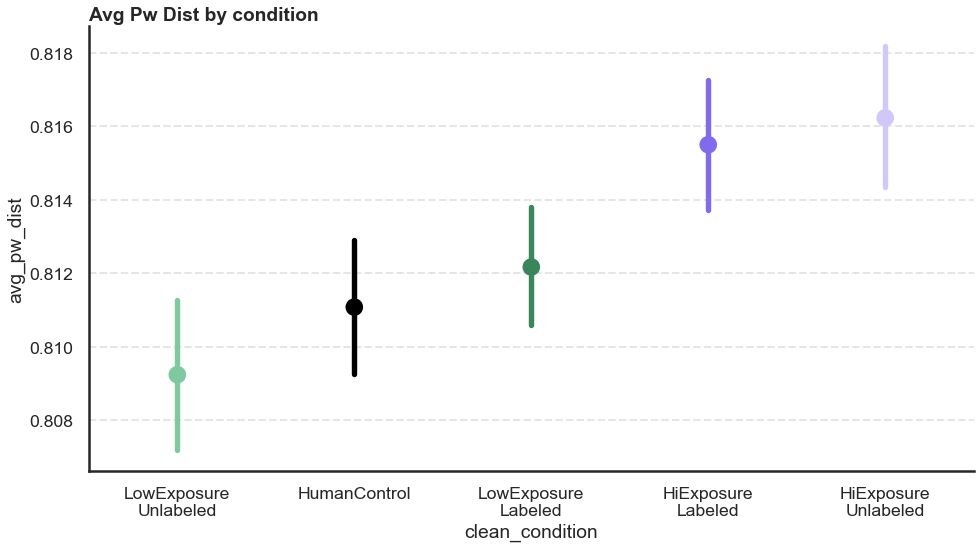

We conducted a Kruskal Wallis test and found max_pw_dist differed by clean_condition, H=111.26, p=3.920678514261962e-23


,group1,group2,group1 mean,group2 mean,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,1.103689,1.095991,0.007698,0.274763,0.000100,0.000999,YES
1,HiExposure\nLabeled,HumanControl,1.103689,1.089159,0.014531,0.545872,0.000100,0.000999,YES
2,HiExposure\nLabeled,LowExposure\nLabeled,1.103689,1.089067,0.014622,0.528314,0.000100,0.000999,YES
3,HiExposure\nLabeled,LowExposure\nUnlabeled,1.103689,1.090487,0.013202,0.448750,0.000100,0.000999,YES
4,HiExposure\nUnlabeled,HumanControl,1.095991,1.089159,0.006833,0.285229,0.000100,0.000999,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,1.095991,1.089067,0.006924,0.275586,0.000100,0.000999,YES
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,1.095991,1.090487,0.005504,0.203609,0.001600,0.015884,YES
7,HumanControl,LowExposure\nLabeled,1.089159,1.089067,0.000092,0.003886,0.951705,1.000000,NO
8,HumanControl,LowExposure\nUnlabeled,1.089159,1.090487,-0.001328,-0.051927,0.415158,0.995319,NO
9,LowExposure\nLabeled,LowExposure\nUnlabeled,1.089067,1.090487,-0.001420,-0.053219,0.397560,0.993703,NO


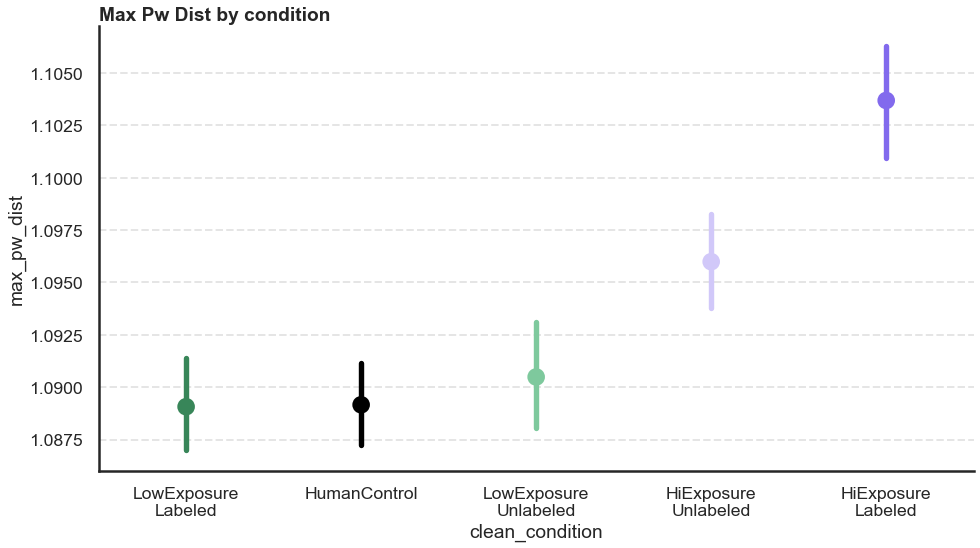

We conducted a Kruskal Wallis test and found median_pw_dist differed by clean_condition, H=26.32, p=2.7328334139162692e-05


,group1,group2,group1 mean,group2 mean,Diff in Means,Cohen's d,p,p_adj,Reject Null
0,HiExposure\nLabeled,HiExposure\nUnlabeled,0.831147,0.832657,-0.001510,-0.067759,0.283072,0.964128,NO
1,HiExposure\nLabeled,HumanControl,0.831147,0.828155,0.002993,0.135676,0.032397,0.280596,NO
2,HiExposure\nLabeled,LowExposure\nLabeled,0.831147,0.829122,0.002025,0.101100,0.114089,0.702215,NO
3,HiExposure\nLabeled,LowExposure\nUnlabeled,0.831147,0.825816,0.005332,0.238894,0.000300,0.002996,YES
4,HiExposure\nUnlabeled,HumanControl,0.832657,0.828155,0.004502,0.197710,0.002100,0.020801,YES
5,HiExposure\nUnlabeled,LowExposure\nLabeled,0.832657,0.829122,0.003535,0.169815,0.007599,0.073446,NO
6,HiExposure\nUnlabeled,LowExposure\nUnlabeled,0.832657,0.825816,0.006842,0.297120,0.000100,0.000999,YES
7,HumanControl,LowExposure\nLabeled,0.828155,0.829122,-0.000967,-0.047024,0.462454,0.997986,NO
8,HumanControl,LowExposure\nUnlabeled,0.828155,0.825816,0.002339,0.102561,0.102390,0.660470,NO
9,LowExposure\nLabeled,LowExposure\nUnlabeled,0.829122,0.825816,0.003307,0.158558,0.010799,0.102890,NO


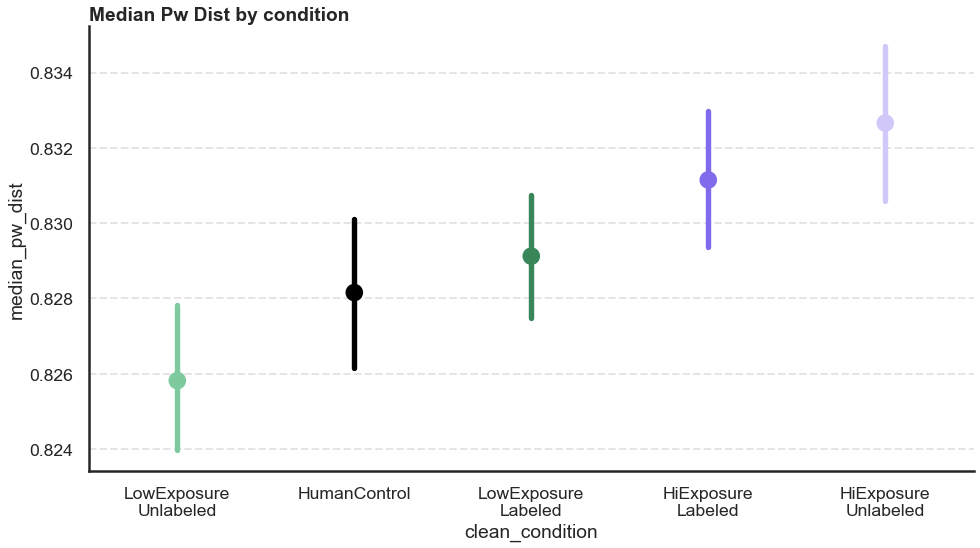

In [18]:
from scipy.spatial.distance import pdist

def compute_embedding_metrics(X):
    # Compute pairwise distances
    dists = pdist(X, 'cosine')
    
    return pd.Series({
        'avg_pw_dist': np.mean(dists),
        'max_pw_dist': np.max(dists),
        'median_pw_dist': np.median(dists)
    })

def process_iteration(tdf, seed):
    np.random.seed(seed)  # set seed for reproducibility
    tdf = tdf.groupby(by=['clean_condition', 'condition', 'item']).sample(n=50, random_state=seed)
    condition_ideas = tdf.groupby(by=['clean_condition', 'condition', 'item'])['response_text'].apply(lambda x: list(x)).reset_index()
    condition_ideas['vectors'] = condition_ideas['response_text'].apply(lambda x: np.vstack([idea2vec[i] for i in x]))
    embedding_metrics = condition_ideas['vectors'].apply(compute_embedding_metrics)
    condition_ideas = pd.concat([condition_ideas, embedding_metrics], axis=1)
    condition_ideas['seed'] = seed
    return condition_ideas

# Run the iterations in parallel using joblib
embedding_results = Parallel(n_jobs=-1)(delayed(process_iteration)(df, i) for i in range(100))
embedding_df = pd.concat(embedding_results)
process_metrics(embedding_df)
